# <font color='darkblue'> Monte Carlo calibration to market data </font>

In [1]:
import pandas as pd
import numpy as np
import os
import signatory
from tqdm.auto import tqdm
import iisignature
import torch
from math import factorial
import multi_moments as mm
from joblib import Parallel,delayed
import esig
import itertools as itt
from scipy.optimize import least_squares,minimize
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

def duplicate(testList, n):
    x=[list(testList) for _ in range(n)]
    flat_list = []
    for sublist in x:
        for item in sublist:
            flat_list.append(item)
    return flat_list

def multi_maturities(maturities,k):
    mat=list(maturities)
    new_multi_mat=[]
    for element in mat:
        for j in range(k):
            new_multi_mat.append(element)
    return np.array(new_multi_mat)

def phi(x): ## Gaussian density
    return np.exp(-x*x/2.)/np.sqrt(2*np.pi)    
#### Black Sholes Vega
def BlackScholesVegaCore(DF,F,X,T,v):   #S=F*DF
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    return F*phi(d1)*np.sqrt(T)/DF


#### Black Sholes Function
def BlackScholesCore(CallPutFlag,DF,F,X,T,v):
    ## DF: discount factor
    ## F: Forward
    ## X: strike
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    d2 = d1-vsqrt
    if CallPutFlag:
        return DF*(F*norm.cdf(d1)-X*norm.cdf(d2))
    else:
        return DF*(X*norm.cdf(-d2)-F*norm.cdf(-d1))
    
##  Black-Scholes Pricing Function
def BlackScholes(CallPutFlag,S,X,T,r,d,v):
    ## r, d: continuous interest rate and dividend
    return BlackScholesCore(CallPutFlag,np.exp(-r*T),np.exp((r-d)*T)*S,X,T,v)
    

def tilde_transformation(word):
    word_aux=word.copy()
    word_aux_2=word.copy()
    if word[-1]==1:
        word.append(2)
        word_aux.append(3)
        return word, word_aux
    if word[-1]!=1:
        word_aux.append(2)
        word_aux_2.append(3)
        word[-1]=1
        return word_aux, word_aux_2, word

def e_tilde_part2_new(words_as_lists):
    tilde=[list(tilde_transformation(words_as_lists[k])) for k in np.array(range(len(words_as_lists)))[1:]] #we skip the empty word
    return tilde

def from_tilde_to_strings_new(tilde): 
    for k in range(len(tilde)):
        if len(tilde[k])==2:
            tilde[k][0]=str(tuple(tilde[k][0])).replace(" ","")
            tilde[k][1]=str(tuple(tilde[k][1])).replace(" ","")
        elif (len(tilde[k])==3 and len(tilde[k][-1])==1):
            tilde[k][0]=str(tuple(tilde[k][0])).replace(" ","")
            tilde[k][1]=str(tuple(tilde[k][1])).replace(" ","")
            tilde[k][-1]=str(tuple(tilde[k][-1])).replace(",","")
        elif len(tilde[k])==3:
            tilde[k][0]=str(tuple(tilde[k][0])).replace(" ","")
            tilde[k][1]=str(tuple(tilde[k][1])).replace(" ","")
            tilde[k][2]=str(tuple(tilde[k][2])).replace(" ","")
    return tilde

def get_tilde_df_debug(Sig_data_frame,new_tilde,keys_n,keys_n1,comp_of_path,rho,y):
    aus_B=[]
    y=[[eval(key)] if isinstance(eval(key), int) else list(eval(key)) for key in keys_n]
    for k in range(len(y)):
        if k==0:
            aus_B.insert(0,Sig_data_frame['(2)'])
        if (k>0 and y[k][-1]==1):
            aus_B.append(Sig_data_frame[new_tilde[k-1][0]])
           
        if (k>0 and y[k][-1]==2):
            aus_B.append(Sig_data_frame[new_tilde[k-1][0]]-0.5*Sig_data_frame[new_tilde[k-1][2]])
        
        if (k>0 and y[k][-1]==3):
            aus_B.append(Sig_data_frame[new_tilde[k-1][0]]-rho*0.5*Sig_data_frame[new_tilde[k-1][2]])
           
    new_keys_B=[keys_n1[k]+str('~B') for k in range(len(y))]
    new_dictionary_B={key:series for key,series in zip(new_keys_B,aus_B)}        
    transformed_data_frame_B=pd.DataFrame(new_dictionary_B)
    return transformed_data_frame_B

def col_stack(element):
    return np.column_stack((element[0],element[1],element[2]))


def correlated_bms_correct(N,rho,t_final,t_0):
    time_grid=np.linspace(0,t_final,num=N,retstep=True)[0]
    dt=np.abs(time_grid[0]-time_grid[1])
    dB = np.random.normal(0, np.sqrt(dt), N)
    dB[0]=0
    dW = rho*dB+np.sqrt(1-(rho)**2)*np.random.normal(0,np.sqrt(dt),N)
    dW[0]=0
    B = np.cumsum(dB)
    W = np.cumsum(dW)
    return time_grid, B, W

In [2]:
moneyness=np.load('strikes_SPX_Bloomberg.npy')
maturities=np.load('maturities_SPX_Bloomberg.npy')
iv_market=np.load('iv_spx_170321_bymat.npy')
market_prices=np.load('prices_optionsSPX_170321.npy')

initial_price=100
strikes_all=duplicate(moneyness*initial_price,len(maturities))
strikes=np.array([np.array(strikes_all[j*(len(moneyness)):(j+1)*(len(moneyness))]) for j in range(len(maturities))])
maturities_ext=multi_maturities(maturities,len(strikes[0]))
strike_flat=strikes.flatten()
option_prices_splitted=np.array(np.split(market_prices,len(maturities)))

In [3]:
#iv_market not sharable due to data provider

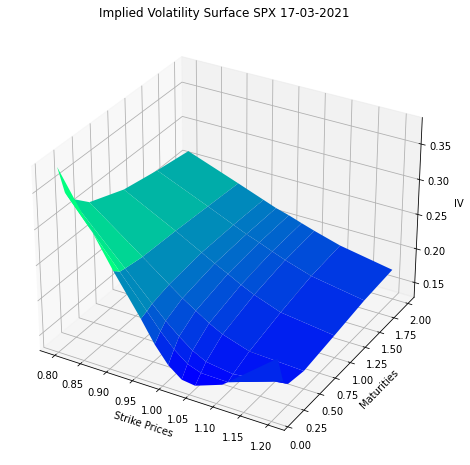

In [4]:
YY=np.array([[maturities[j]]*(len(strikes[0])) for j in range(len(maturities))])

%matplotlib inline
fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection='3d')


ax.plot_surface(strikes/100, YY, iv_market, rstride=1, cstride=1,
                cmap=cm.winter,linewidth=0.5, edgecolor='none')

ax.set_xlabel('Strike Prices')
ax.set_ylabel('Maturities')
ax.set_zlabel('IV')
ax.set_title('Implied Volatility Surface SPX 17-03-2021');

In [5]:
prices_scaled=option_prices_splitted/100
#print(prices_scaled)

In [6]:
initial_price=1

In [7]:
if initial_price==100:
    Premium=market_prices
elif initial_price==1:
    Premium=prices_scaled.flatten()

##### Compute Vega weights


In [8]:
strikes=strikes/100 #run only once

In [9]:
def get_vegas(maturities, strikes, initial_price, iv_market, flag_truncation):
    vega=[]
    for i in range(len(maturities)):
        for j in range(len(strikes[i])):
            if flag_truncation==True:
                vega.append(min(1/(BlackScholesVegaCore(1,initial_price,strikes[i][j],maturities[i],iv_market[i,j])),1))
            else:
                vega.append(1/(BlackScholesVegaCore(1,initial_price,strikes[i][j],maturities[i],iv_market[i,j])))
    vega=np.array(vega)

    vega_by_mat=np.array(np.split(vega,len(maturities)))
    sums_each_strike=np.sum(vega_by_mat, axis=1)
    normalized_vega=np.array([vega_by_mat[j]/sums_each_strike[j] for j in range(len(maturities))])
    flat_normal_weights=normalized_vega.flatten()
    return flat_normal_weights, normalized_vega

In [10]:
flag_truncation=False #Truncation was introduced by Cont and Ben Hamida (2011)
flat_normal_weights, norm_vegas=get_vegas(maturities, strikes, initial_price, iv_market, flag_truncation)

In [11]:
def one_step_MC_mat_truncation_last(rho,n,maturity):
    '''
    Inputs:
    N (int): number of points for each simulation
    rho (float): number in (-1,1), correlation coefficient of the sampled Brownians
    n (int): order of truncation of the Signature Model under Q
    list_of_maturities (list): list of floats, where each float is a maturity
    Output:
    Pandas Data Frame of the tilde-Signature of the Brownian driving the price
    '''
    N=int(maturity*365.25)
    time_and_bms=correlated_bms_correct(N,rho,maturity,0)
    augmented_bms=col_stack(time_and_bms)
    augmented_bms=torch.from_numpy(augmented_bms).unsqueeze(0)
    sig=signatory.signature(augmented_bms,n+1,stream=True,basepoint=True,scalar_term=True)
    nbr_components=augmented_bms.shape[-1]
    keys_n1=esig.sigkeys(nbr_components,n+1).strip().split(" ")
    keys_n=esig.sigkeys(nbr_components,n).strip().split(" ")
    y=[[eval(key)] if isinstance(eval(key), int) else list(eval(key)) for key in keys_n]
    first_step=e_tilde_part2_new(y)
    new_tilde=from_tilde_to_strings_new(first_step)
    sig_df=pd.DataFrame(sig.squeeze(0).numpy(), columns=keys_n1)
    tilde_sig_df=get_tilde_df_debug(sig_df,new_tilde,keys_n,keys_n1,nbr_components,rho,y)
    tilde_sig_df_by_mat=np.array(tilde_sig_df.iloc[-1,:])
    
    return tilde_sig_df_by_mat

In [12]:
MC_number, rho, n= 100, -0.5, 2
rho_matrix=[[1,rho],[rho,1]]
d,D=2,1

In [13]:
grid=np.array([int(T*365.25) for T in maturities])
maturity_dict=dict(zip(maturities, grid.T))
maturity_dict

nbr_components=len(rho_matrix)+1
keys_n1=esig.sigkeys(nbr_components,n+1).strip().split(" ")
keys_n=esig.sigkeys(nbr_components,n).strip().split(" ")
y=[[eval(key)] if isinstance(eval(key), int) else list(eval(key)) for key in keys_n]
first_step=e_tilde_part2_new(y)
new_tilde=from_tilde_to_strings_new(first_step)

def auxiliar_function(idx_mat,n,nbr_components,keys_n1,keys_n,new_tilde,maturity_dict):
    time_and_bms=correlated_bms_correct(maturity_dict[maturities[idx_mat]],rho,maturities[idx_mat],0)
    augmented_bms=col_stack(time_and_bms)
    augmented_bms=torch.from_numpy(augmented_bms).unsqueeze(0)
    sig=signatory.signature(augmented_bms,n+1,stream=True,basepoint=True,scalar_term=True)
    sig_df=pd.DataFrame(sig.squeeze(0).numpy(), columns=keys_n1)
    tilde_sig_df=get_tilde_df_debug(sig_df,new_tilde,keys_n,keys_n1,nbr_components,rho,y)
    tilde_sig_df_by_mat=np.array(tilde_sig_df.iloc[-1,:])
    return tilde_sig_df_by_mat

def auxiliar_function_all_mat(n,nbr_components,keys_n1,keys_n,new_tilde,maturity_dict):
    get_model=[auxiliar_function(j,n,nbr_components,keys_n1,keys_n,new_tilde,maturity_dict) for j in range(len(maturities))]
    #Parallel(n_jobs=?)(delayed(auxiliar_function)(j,n,nbr_components,keys_n1,keys_n,new_tilde,maturity_dict) for j in range(len(maturities)))
    get_model=np.array(get_model)
    return get_model

get_model=auxiliar_function_all_mat(n,nbr_components,keys_n1,keys_n,new_tilde,maturity_dict)
arr_dfs_bymat=np.array(Parallel(n_jobs=-1)(delayed(auxiliar_function_all_mat)(n,nbr_components,keys_n1,keys_n,new_tilde,maturity_dict) for k in tqdm(range(MC_number),desc='Getting Model at all maturities')))


Getting Model at all maturities:   0%|          | 0/100 [00:00<?, ?it/s]

In [14]:
arr_dfs_by_mat=np.swapaxes(arr_dfs_bymat,0,1)
print('Shape Arr_Dfs_By_Mat:', arr_dfs_by_mat.shape)

Shape Arr_Dfs_By_Mat: (7, 100, 13)


In [15]:
#arr_dfs_by_mat=np.swapaxes(arr_dfs_by_mat,0,1) #swapaxes if necessary in the codes
#arr_dfs_by_mat.shape

The previous is the offline routine to compute $<\tilde{e}_{I},\widehat{\mathbb{X}}_{T}(\omega_{i})>$ for all $\lvert I \lvert \le n$, all $i=1,\dots,N_{MC}$ and $T>0$ maturity. In particular if $\texttt{arr_dfs_by_mat}$ is of dimension $(7,100,13)$, it means that we have $N_{MC}=100$, $n=2$ and 7 different maturities, namely the one from the data.

## Calibration to a set of selected maturities' slice

Observe that this approach is the one implemented to reproduce the analysis of Figure 6 in the article. Namely fit first and second maturity together varying the order of the signature.

In [60]:
os.chdir(r'C:\Users\Guido Gazzani\ucloud\Shared\SigSDEs_ucloud\Code_real_data\Cluster_files')
arr_dfs_by_mat=np.load('arr_dfs_by_mat((7, 1000000, 13)).npy')

arr_dfs_by_mat.shape

(7, 1000000, 13)

In [16]:
index_sel_maturities=[0,1]
sel_maturities=[maturities[0],maturities[1]]

In [17]:
Vega_W=np.array([np.split(flat_normal_weights,len(maturities))[idx] for idx in index_sel_maturities]).flatten()
Premium1=np.array([np.split(prices_scaled,len(maturities))[idx] for idx in index_sel_maturities]).flatten()

In [18]:
def get_mc_sel_mat_tensor(l):
    '''
    Input: l (np.array): a set of parameters of the model, mind the dimension
    Output: Monte Carlo prices of the model with parameters l for the selected maturities
    '''
    tensor_sigsde_at_mat=np.tensordot(arr_dfs_by_mat,l,axes=1)+initial_price
    pay=[]
    for K in strikes[0]:
        matrix_big=[]
        for j in index_sel_maturities:
            payff=np.maximum(0, tensor_sigsde_at_mat[j] - K)
            matrix_big.append(payff)
        matrix=np.array(matrix_big)
        pay.append(np.mean(matrix,axis=1))
    mc_payoff_arr=np.array(pay).transpose().flatten()
    return mc_payoff_arr

#range(len(sel_maturities))

In [20]:
l_initial=np.random.uniform(-0.1,0.1,int(((d+1)**(n+1)-1)*D/d))

In [19]:
def obj_MC_tensor_selected_mat(l):
    mc_payoff_arr=get_mc_sel_mat_tensor(l)   
    return np.sqrt(Vega_W)*(mc_payoff_arr-Premium1)

In [494]:
#Optimization routine, stores the ell* in the folder 
n=2
for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.2,0.2,int(((d+1)**(n+1)-1)*D/d))
    res1 = least_squares(obj_MC_tensor_selected_mat, l_initial,loss='linear')

#np.save(f'ell_MC({n},{m},{d},{rho},{MC_number},{initial_price},{index_sel_maturities}).npy',res1['x'])

  0%|          | 0/1 [00:00<?, ?it/s]

In [495]:
calibrated_prices=get_mc_sel_mat_tensor(res1['x'])
#np.save(f'calibrated_prices_MC({MC_number},{initial_price},{index_sel_maturities})',calibrated_prices)

In [94]:
iv_, prices_= get_iv_from_calib(calibrated_prices,strikes,sel_maturities)

### In the following the upload the previous results, i.e.,  for $n=2,3,4,5$ when fitting the two shortest maturities together.

It is important to mention that we provide the precomputed $\texttt{arr_dfs_by_mat}$ for the case $n=2$; for $n=3,4,5$ it can be computed offline via the previous functions.

In [20]:
import os
os.getcwd()

'C:\\Users\\Guido Gazzani\\ucloud\\Shared\\SigSDEs_ucloud\\Code_real_data\\Cluster_files'

In [21]:
from scipy.optimize import minimize_scalar
from scipy.stats import norm
from matplotlib import cm
def implied_vol_minimize( price, S0, K, T, r, payoff="call", disp=True ):
    """ Returns Implied volatility by minimization"""
    
    n = 2     # must be even
    def obj_fun(vol):
        return ( BlackScholes(True, S0, K, T, r, 0., vol) - price)**n
        
    res = minimize_scalar( obj_fun, bounds=(1e-15, 8), method='bounded')
    if res.success == True:
        return res.x       
    if disp == True:
        print("Strike", K)
    return -1


def phi(x): ## Gaussian density
    return np.exp(-x*x/2.)/np.sqrt(2*np.pi)

#### Black Sholes Function
def BlackScholesCore(CallPutFlag,DF,F,X,T,v):
    ## DF: discount factor
    ## F: Forward
    ## X: strike
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    d2 = d1-vsqrt
    if CallPutFlag:
        return DF*(F*norm.cdf(d1)-X*norm.cdf(d2))
    else:
        return DF*(X*norm.cdf(-d2)-F*norm.cdf(-d1))
    
#### Black Sholes Vega
def BlackScholesVegaCore(DF,F,X,T,v):   #S=F*DF
    vsqrt=v*np.sqrt(T)
    d1 = (np.log(F/X)+(vsqrt*vsqrt/2.))/vsqrt
    return F*phi(d1)*np.sqrt(T)/DF
    
##  Black-Scholes Pricing Function
def BlackScholes(CallPutFlag,S,X,T,r,d,v):
    ## r, d: continuous interest rate and dividend
    return BlackScholesCore(CallPutFlag,np.exp(-r*T),np.exp((r-d)*T)*S,X,T,v)

def get_iv_from_calib(calibrated_prices,strikes,maturities):
    sig_prices_mc_arr=[]
    iv_calib_mc=[]
    
    sig_prices_mc_arr=np.array(np.split(calibrated_prices,len(maturities)))
        
    for j in range(len(maturities)):
        for k in range(len(strikes[j])):
                iv_calib_mc.append(implied_vol_minimize(sig_prices_mc_arr[j,k], initial_price, strikes[j][k], maturities[j], 0, payoff="call", disp=True))

    iv_calib_arr_mc=np.array([np.array(iv_calib_mc[k*len(strikes[0]):(k+1)*len(strikes[0])]) for k in range(len(maturities))])
    return iv_calib_arr_mc, sig_prices_mc_arr

# $n=2,3,4,5$ display results

In [22]:
sel_maturities=maturities[:2]

In [23]:
calibrated_prices_02=np.load('calibrated_prices_MC(1000000,1,[0, 1],2).npy')
ell_calibrated_02=np.load('ell_MC(2,2,-0.5,1000000,1,[0, 1]).npy')
calibrated_prices_03=np.load('calibrated_prices_MC(1000000,1,[0,1],3).npy')
ell_calibrated_03=np.load('ell_MC(3,2,-0.5,1000000,1,[0,1]).npy')
calibrated_prices_04=np.load('calibrated_prices_MC(1000000,1,[0, 1],4).npy')
ell_calibrated_04=np.load('ell_MC(4,2,-0.5,1000000,1,[0, 1]).npy')
calibrated_prices_05=np.load('calibrated_prices_MC(1000000,1,[0, 1],5).npy')
ell_calibrated_05=np.load('ell_MC(5,2,-0.5,1000000,1,[0, 1]).npy')
iv_calib_arr_mc_2,sig_prices_mc_arr_2=get_iv_from_calib(calibrated_prices_02,strikes,sel_maturities)
iv_calib_arr_mc_3,sig_prices_mc_arr_3=get_iv_from_calib(calibrated_prices_03,strikes,sel_maturities)
iv_calib_arr_mc_4,sig_prices_mc_arr_4=get_iv_from_calib(calibrated_prices_04,strikes,sel_maturities)
iv_calib_arr_mc_5,sig_prices_mc_arr_5=get_iv_from_calib(calibrated_prices_05,strikes,sel_maturities)

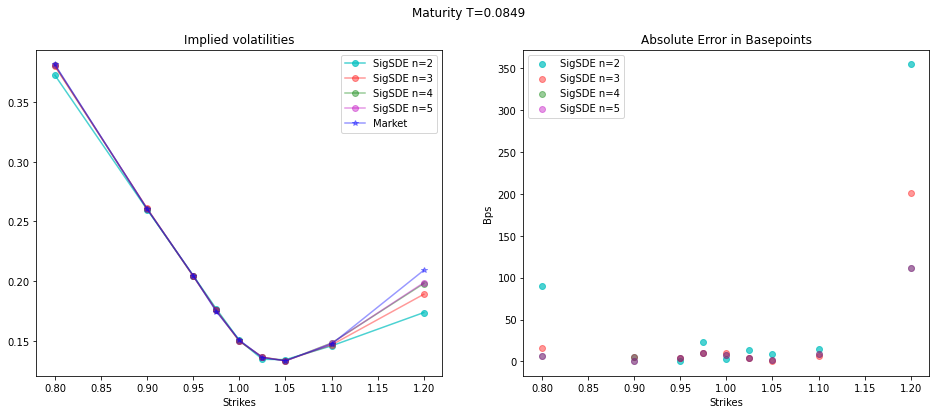

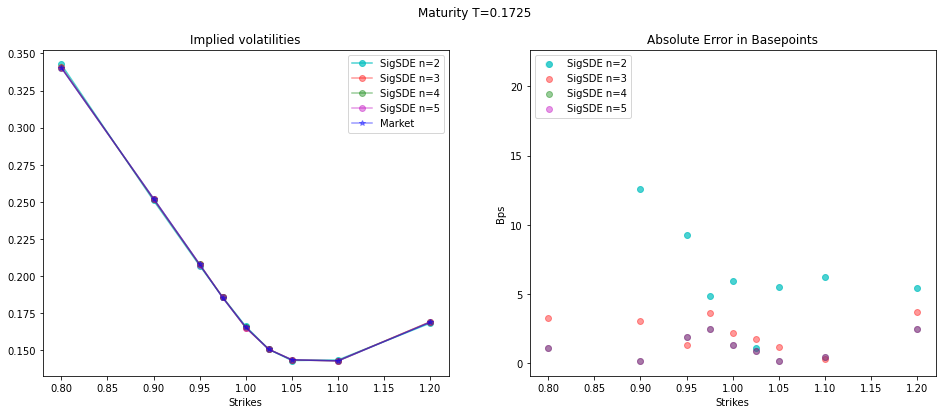

In [24]:
%matplotlib inline

for j in range(len(sel_maturities)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
    fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
    ax1.plot(strikes[j], iv_calib_arr_mc_2[j],marker='o',color='c',alpha=0.7,label='SigSDE n=2')
    ax1.plot(strikes[j], iv_calib_arr_mc_3[j],marker='o',color='r',alpha=0.4,label='SigSDE n=3')
    ax1.plot(strikes[j], iv_calib_arr_mc_4[j],marker='o',color='g',alpha=0.4,label='SigSDE n=4')
    ax1.plot(strikes[j], iv_calib_arr_mc_5[j],marker='o',color='m',alpha=0.4,label='SigSDE n=5')
    ax1.plot(strikes[j], iv_market[j],marker='*',alpha=0.4,color='b',label='Market')
    ax1.set_xlabel('Strikes')
    ax1.set_title('Implied volatilities')
    ax2.scatter(strikes[j],np.abs(iv_calib_arr_mc_2[j]-iv_market[j])*10000,color='c',alpha=0.7,label='SigSDE n=2')
    ax2.scatter(strikes[j],np.abs(iv_calib_arr_mc_3[j]-iv_market[j])*10000,color='r',alpha=0.4,label='SigSDE n=3')
    ax2.scatter(strikes[j],np.abs(iv_calib_arr_mc_4[j]-iv_market[j])*10000,color='g',alpha=0.4,label='SigSDE n=4')
    ax2.scatter(strikes[j],np.abs(iv_calib_arr_mc_4[j]-iv_market[j])*10000,color='m',alpha=0.4,label='SigSDE n=5')# *10000
    ax2.set_xlabel('Strikes')
    ax2.set_ylabel('Bps')
    ax2.set_title('Absolute Error in Basepoints')
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper left')
    plt.savefig('Fit_MC_(T={}'.format(round(maturities[j],4))+', all).png',dpi=100)
    plt.show()

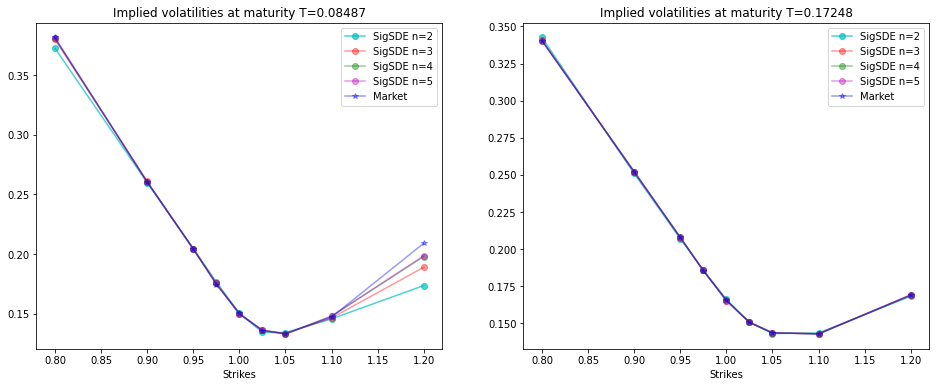

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))
#fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
j=0
ax1.plot(strikes[j], iv_calib_arr_mc_2[j],marker='o',color='c',alpha=0.7,label='SigSDE n=2')
ax1.plot(strikes[j], iv_calib_arr_mc_3[j],marker='o',color='r',alpha=0.4,label='SigSDE n=3')
ax1.plot(strikes[j], iv_calib_arr_mc_4[j],marker='o',color='g',alpha=0.4,label='SigSDE n=4')
ax1.plot(strikes[j], iv_calib_arr_mc_5[j],marker='o',color='m',alpha=0.4,label='SigSDE n=5')
ax1.plot(strikes[j], iv_market[j],marker='*',alpha=0.4,color='b',label='Market')
ax1.set_xlabel('Strikes')
ax1.set_title('Implied volatilities at maturity T={}'.format(round(maturities[j],5)))
j=1
ax2.plot(strikes[j], iv_calib_arr_mc_2[j],marker='o',color='c',alpha=0.7,label='SigSDE n=2')
ax2.plot(strikes[j], iv_calib_arr_mc_3[j],marker='o',color='r',alpha=0.4,label='SigSDE n=3')
ax2.plot(strikes[j], iv_calib_arr_mc_4[j],marker='o',color='g',alpha=0.4,label='SigSDE n=4')
ax2.plot(strikes[j], iv_calib_arr_mc_5[j],marker='o',color='m',alpha=0.4,label='SigSDE n=5')
ax2.plot(strikes[j], iv_market[j],marker='*',alpha=0.4,color='b',label='Market')
ax2.set_xlabel('Strikes')
ax2.set_title('Implied volatilities at maturity T={}'.format(round(maturities[j],5)))

ax1.legend(loc='upper right')
ax2.legend(loc='upper right')
plt.savefig('Fit_MC_([0,1], all).png',dpi=100)
plt.show()

In the following we can see that if we fit indipendently (so without the adjustment discussed for the time-varying parameter version of the model), the optimal parameters obtain differ strongly between the first and the last maturity. In particular the two shortest maturity attain greater values w.r.t. longer maturities, therefore forcing a single parameter set will probably yield unsatisfactory results in the calibration of the whole surface. As follows the case for $n=2$, $n=3$.

# Slice-wise with $n=2$

Shape: (7, 13)


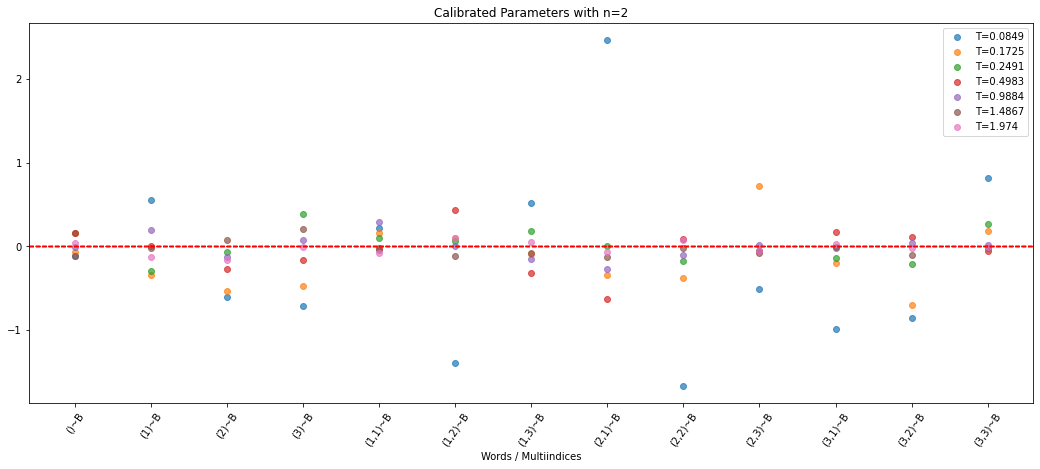

In [26]:
n=2
set_of_calibrated_prices=[]
for j in range(len(maturities)):
    set_of_calibrated_prices.append(np.load(f'calibrated_prices_MC(1000000,1,[{j}],{n}).npy'))
set_of_calibrated_prices=np.array(set_of_calibrated_prices)
set_of_calibrated_params=[]
for j in range(len(maturities)):
    set_of_calibrated_params.append(np.load(f'ell_MC({n},2,-0.5,1000000,1,[{j}]).npy'))
set_of_calibrated_params=np.array(set_of_calibrated_params)

print('Shape:', set_of_calibrated_params.shape)
chiavi=np.array([esig.sigkeys(3,n).strip('').split()[k]+str('~B') for k in range(set_of_calibrated_params.shape[1])])

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(18,7))
for j in range(len(maturities)):
    ax.axhline(y=0,color='r', linestyle='--',linewidth=1.2)
    ax.scatter(chiavi, set_of_calibrated_params[j,:],marker='o',alpha=0.7,label='T={}'.format(round(maturities[j],4)))
    ax.set_xlabel('Words / Multiindices')
    plt.setp(ax.get_xticklabels(), rotation=55)
    ax.set_title('Calibrated Parameters with n={}'.format(n))
ax.legend()
#plt.savefig('slicewise_calibrated_param_(n=2).png',dpi=100)
plt.show()

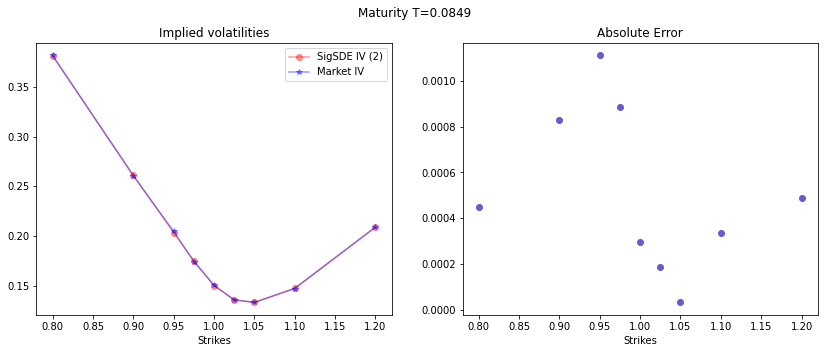

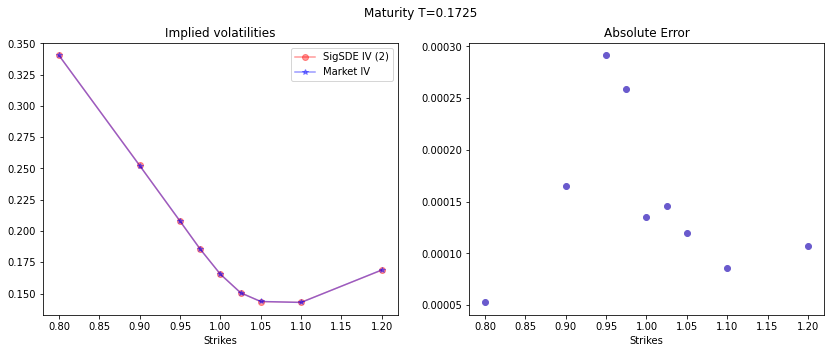

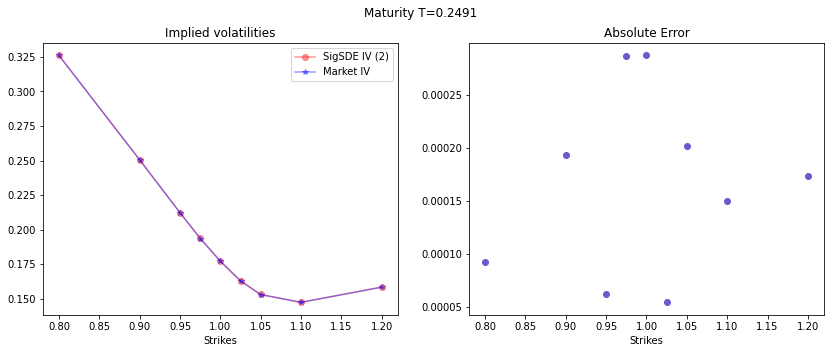

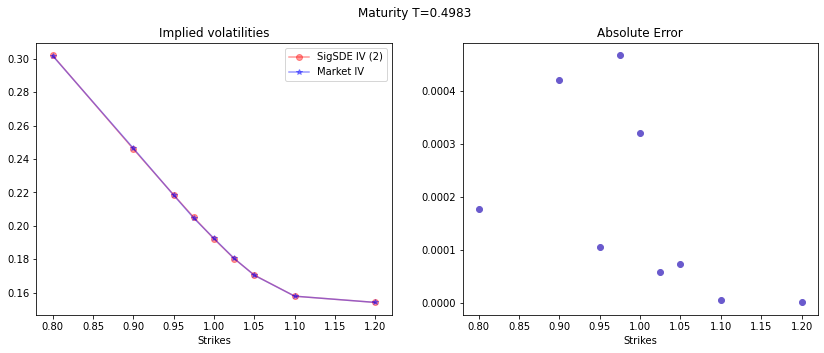

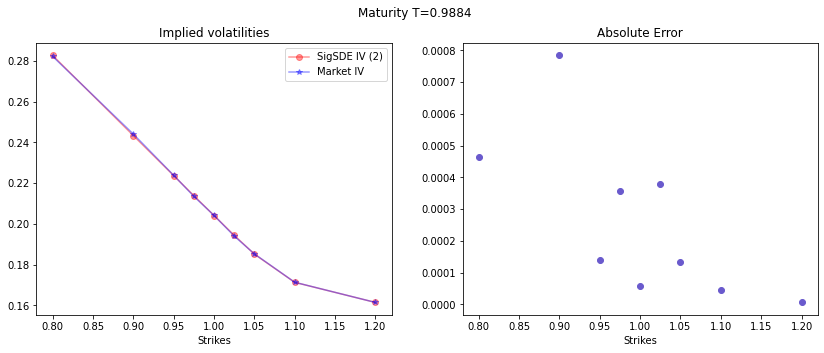

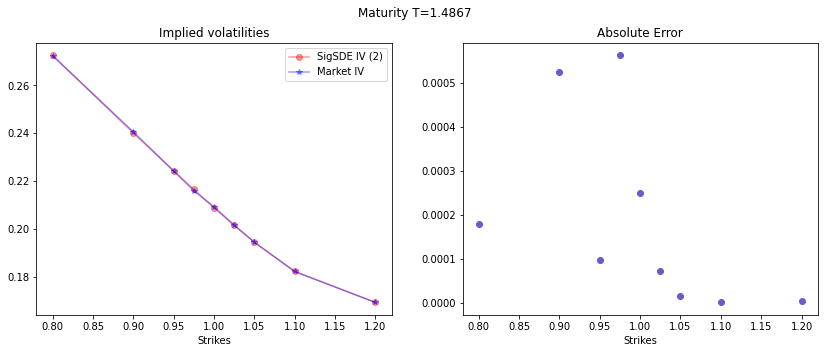

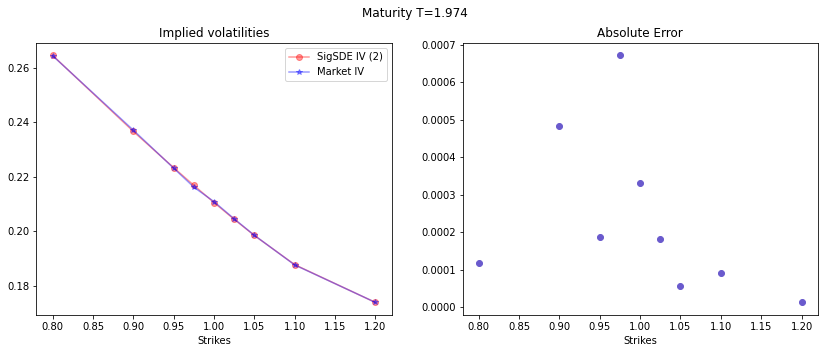

In [27]:
iv_mc=[]
%matplotlib inline
for j in range(len(maturities)):
    iv_calib_arr_mc_slice,sig_prices_mc_arr_slice=get_iv_from_calib(set_of_calibrated_prices[j],strikes,[maturities[j]])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
    ax1.plot(strikes[j], iv_calib_arr_mc_slice.squeeze(0),marker='o',color='r',alpha=0.4,label=f'SigSDE IV ({n})')
    iv_mc.append(iv_calib_arr_mc_slice.squeeze(0))
    ax1.plot(strikes[j], iv_market[j],marker='*',alpha=0.4,color='b',label='Market IV')
    ax1.set_xlabel('Strikes')
    ax1.set_title('Implied volatilities')
    ax2.scatter(strikes[j],np.abs( iv_calib_arr_mc_slice.squeeze(0)-iv_market[j]),color='slateblue')# *10000
    ax2.set_xlabel('Strikes')
    #ax2.set_ylabel('Bps')
    ax2.set_title('Absolute Error')
    ax1.legend()
    #plt.savefig('Fit_MC_(T={}'.format(round(maturities[j],4))+', with n=4).png',dpi=1000)
    plt.show()

# Slice-wise with $n=3$

Shape: (7, 40)


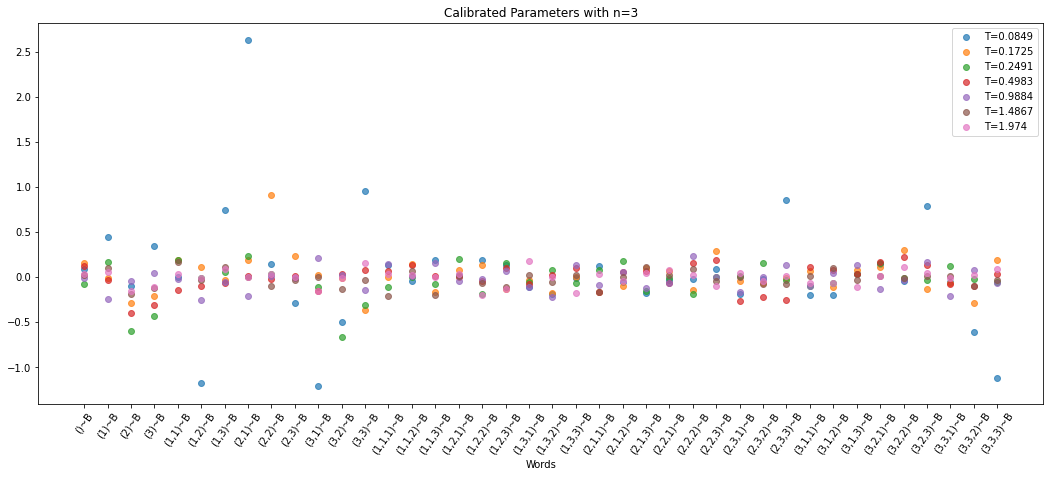

In [28]:
n=3
set_of_calibrated_prices=[]
for j in range(len(maturities)):
    set_of_calibrated_prices.append(np.load(f'calibrated_prices_MC(1000000,1,[{j}],{n}).npy'))
set_of_calibrated_prices=np.array(set_of_calibrated_prices)
set_of_calibrated_params=[]
for j in range(len(maturities)):
    set_of_calibrated_params.append(np.load(f'ell_MC({n},2,-0.5,1000000,1,[{j}]).npy'))
set_of_calibrated_params=np.array(set_of_calibrated_params)

print('Shape:', set_of_calibrated_params.shape)
chiavi=np.array([esig.sigkeys(3,n).strip('').split()[k]+str('~B') for k in range(set_of_calibrated_params.shape[1])])

%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(18,7))
for j in range(len(maturities)):
    ax.scatter(chiavi, set_of_calibrated_params[j,:],marker='o',alpha=0.7,label='T={}'.format(round(maturities[j],4)))
    ax.set_xlabel('Words')
    plt.setp(ax.get_xticklabels(), rotation=55)
    ax.set_title('Calibrated Parameters with n={}'.format(n))
ax.legend()
plt.show()

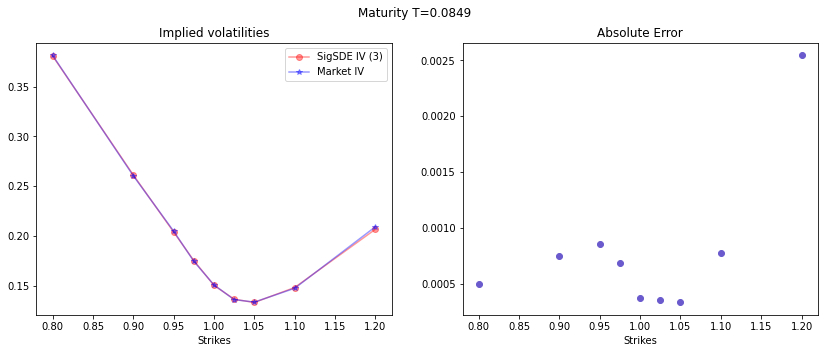

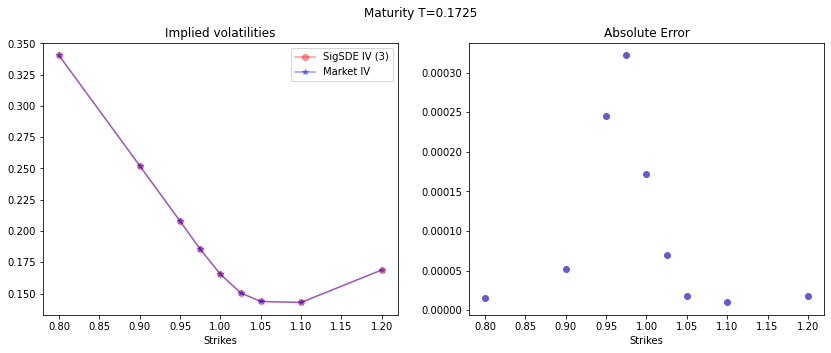

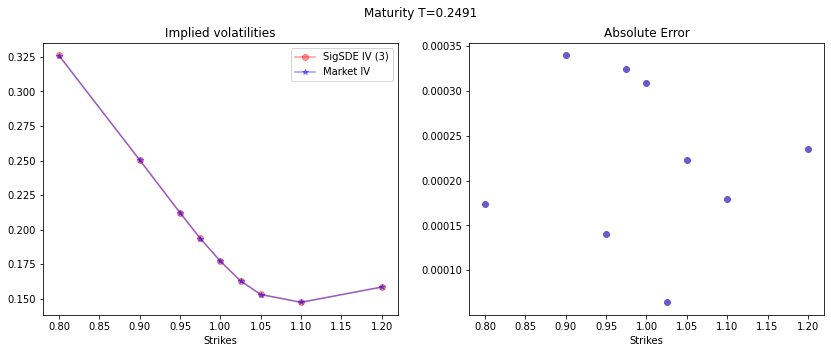

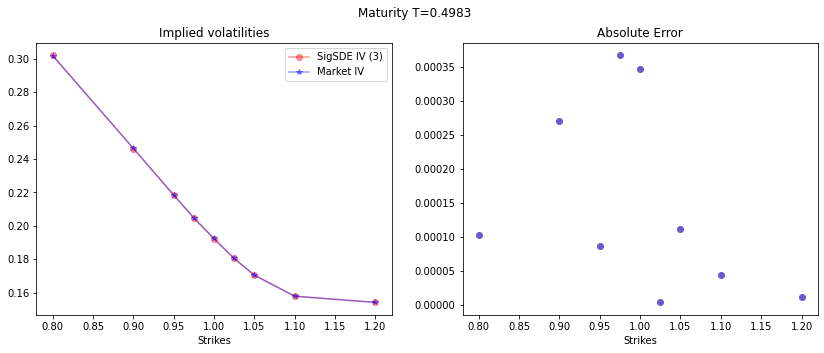

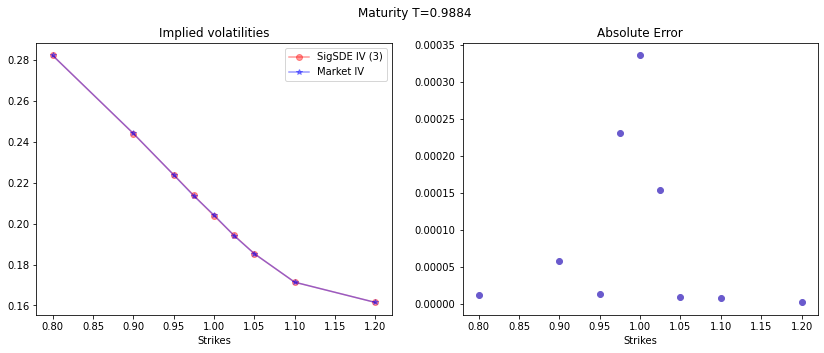

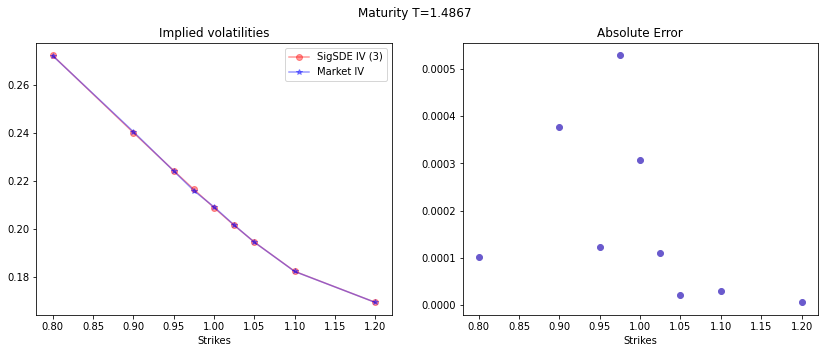

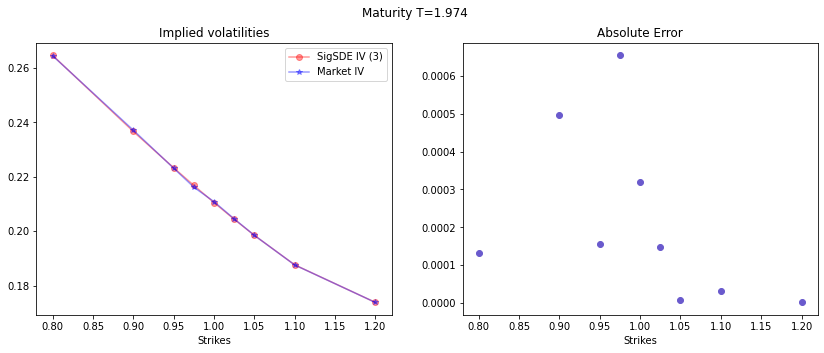

In [29]:
iv_mc=[]
%matplotlib inline
for j in range(len(maturities)):
    iv_calib_arr_mc_slice,sig_prices_mc_arr_slice=get_iv_from_calib(set_of_calibrated_prices[j],strikes,[maturities[j]])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
    ax1.plot(strikes[j], iv_calib_arr_mc_slice.squeeze(0),marker='o',color='r',alpha=0.4,label=f'SigSDE IV ({n})')
    iv_mc.append(iv_calib_arr_mc_slice.squeeze(0))
    ax1.plot(strikes[j], iv_market[j],marker='*',alpha=0.4,color='b',label='Market IV')
    ax1.set_xlabel('Strikes')
    ax1.set_title('Implied volatilities')
    ax2.scatter(strikes[j],np.abs( iv_calib_arr_mc_slice.squeeze(0)-iv_market[j]),color='slateblue')# *10000
    ax2.set_xlabel('Strikes')
    #ax2.set_ylabel('Bps')
    ax2.set_title('Absolute Error')
    ax1.legend()
    #plt.savefig('Fit_MC_(T={}'.format(round(maturities[j],4))+', with n=4).png',dpi=1000)
    plt.show()
    

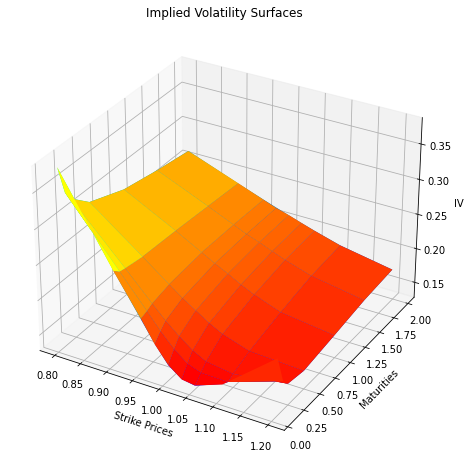

In [30]:
iv_mc=np.array(iv_mc)
YY=np.array([[maturities[j]]*(len(strikes[0])) for j in range(len(maturities))])

%matplotlib inline
fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection='3d')
#ax.plot_surface(strikes, YY, iv_mc, rstride=1, cstride=1,
#                cmap=cm.winter,linewidth=0.5, edgecolor='none')


surf=ax.plot_surface(strikes, YY, iv_mc, rstride=1, cstride=1,
                cmap=cm.winter,linewidth=0.5, edgecolor='none')
ax.plot_surface(strikes, YY, iv_market, rstride=1, cstride=1,
                cmap=cm.autumn,linewidth=0.5, edgecolor='none')

ax.set_xlabel('Strike Prices')
ax.set_ylabel('Maturities')
ax.set_zlabel('IV')
ax.set_title('Implied Volatility Surfaces');

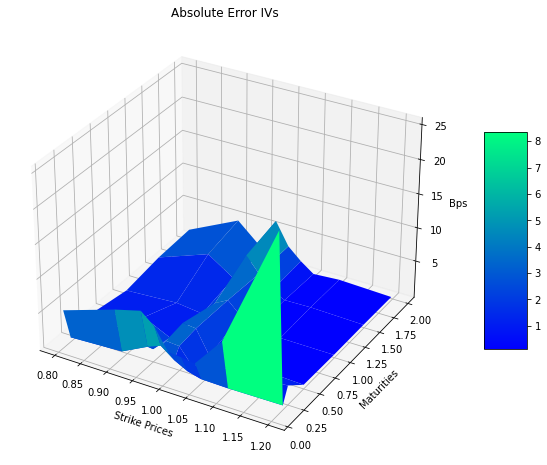

In [32]:
%matplotlib inline
fig = plt.figure(figsize=(15,8))
ax = plt.axes(projection='3d')
surf=ax.plot_surface(strikes, YY, np.abs(iv_mc-iv_market)*10000, rstride=1, cstride=1,
                cmap=cm.winter,linewidth=0.5, edgecolor='none')
ax.set_xlabel('Strike Prices')
ax.set_ylabel('Maturities')
ax.set_zlabel('Bps')
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_title('Absolute Error IVs');

# Slice-wise first maturity and all the rest

This case shows that with $n=4$ we clearly fit indipendently the first maturity, and the last five, but the second one is not reproduced. Therefore potentially with 3 parameter sets we would obtain similar results as above; namely one set of parameter for $T_1$, one for $T_{2}$ and one for $\{T_{3},T_{4},T_{5},T_{6},T_{7}\}$.

In [536]:
n=4
ell_mc_1mat=np.load('ell_MC(4,2,-0.5,1000000,1,[0]).npy')
ell_mc_rest=np.load('ell_MC(4,2,-0.5,1000000,1,(1, 7)).npy')
calibrated_p=[]
calibrated_p.append(ell_mc_1mat)
calibrated_p.append(ell_mc_rest)
calibrated_p=np.array(calibrated_p)

In [537]:
chiavi_n4=np.array([esig.sigkeys(3,4).strip('').split()[k]+str('~B') for k in range(calibrated_p.shape[1])])

In [540]:
list_label=['First Mat.','All other Mat.']

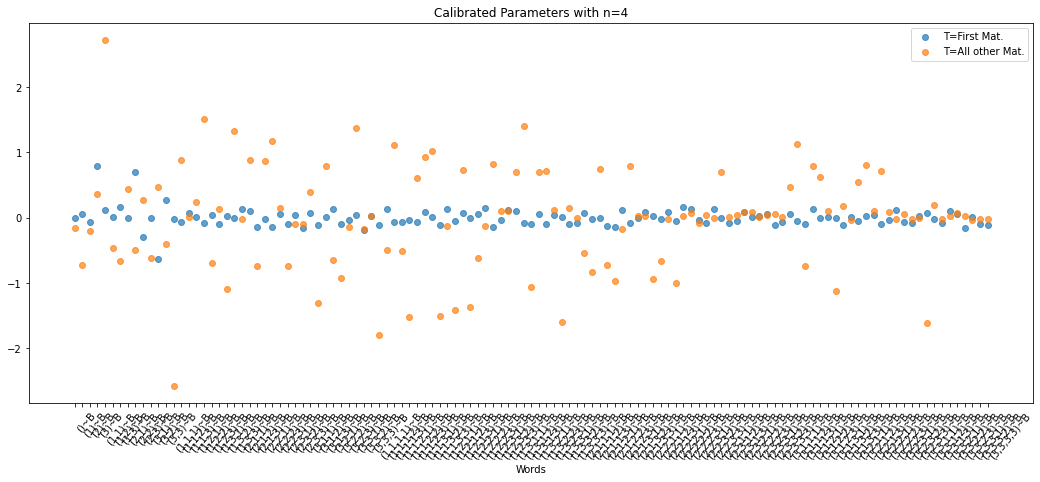

In [553]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(18,7))
for j in range(calibrated_p.shape[0]):
    ax.scatter(chiavi_n4, calibrated_p[j,:],marker='o',alpha=0.7,label='T={}'.format(list_label[j]))
    ax.set_xlabel('Words')
    plt.setp(ax.get_xticklabels(), rotation=50,fontsize = 10,  ha='left')
    ax.set_title('Calibrated Parameters with n={}'.format(n))
ax.legend()
plt.show()

In [626]:
calib_p_1mat=np.load('calibrated_prices_MC(1000000,1,[0],4).npy')
calib_p_rest=np.load('calibrated_prices_MC(1000000,1,(1, 7),4).npy')
calib_p=np.insert(calib_p_rest,0,calib_p_1mat)
calib_p=np.array(np.split(calib_p,len(maturities)))

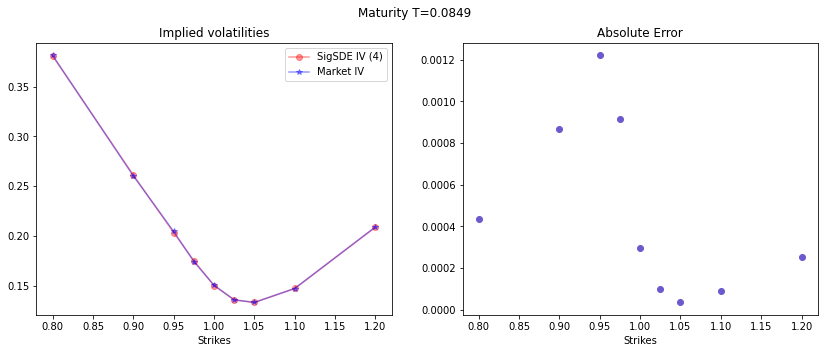

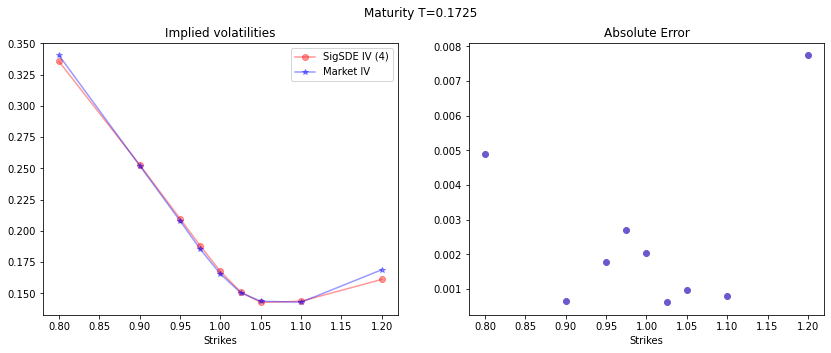

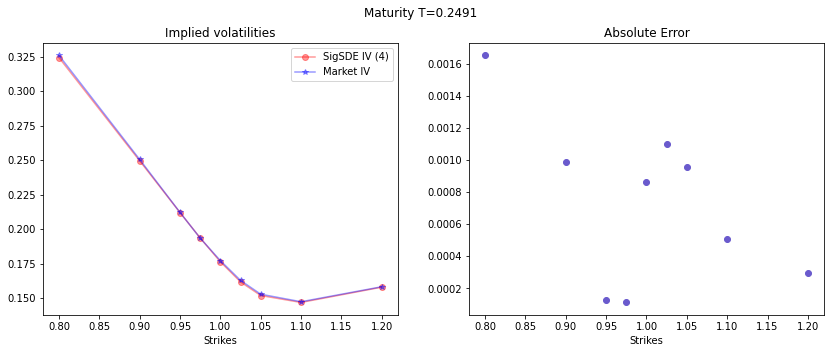

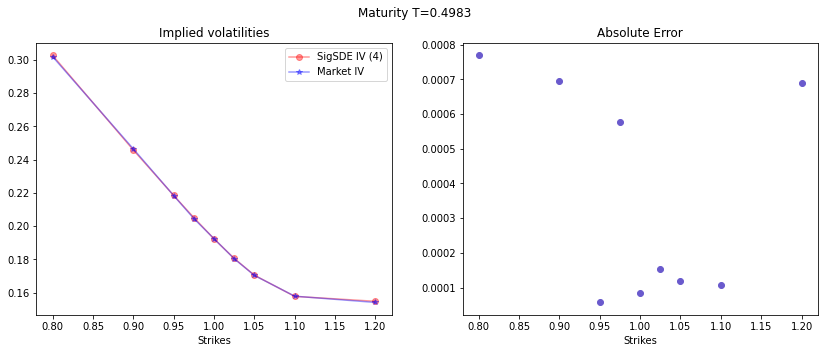

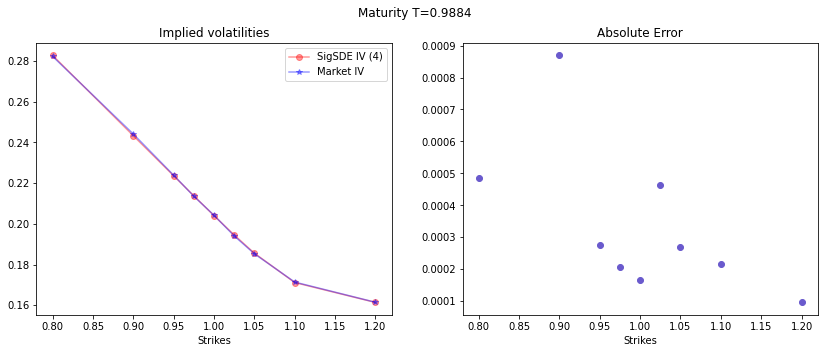

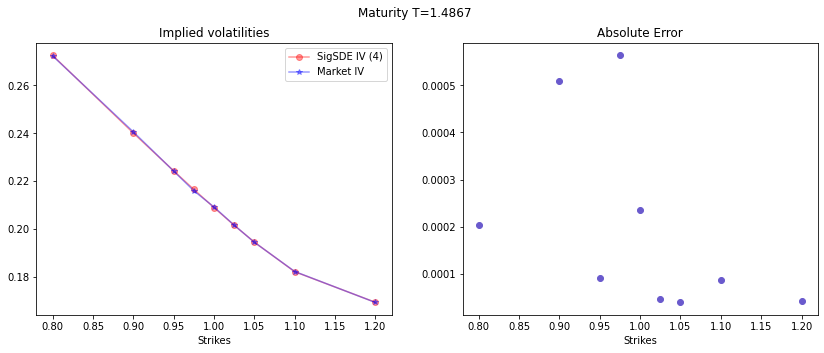

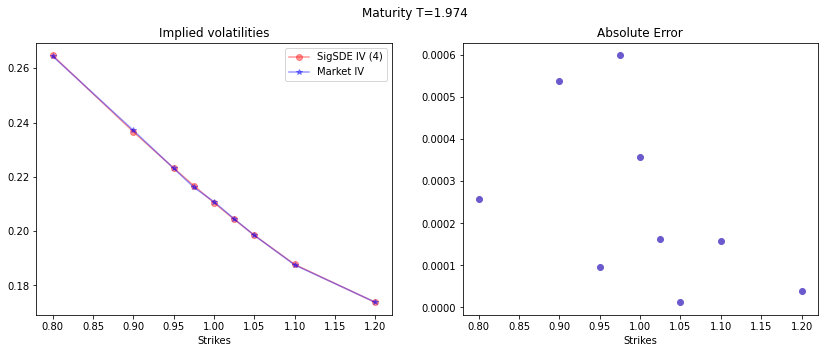

In [627]:
%matplotlib inline
for j in range(len(maturities)):
    iv_4_slice,calib_p_4=get_iv_from_calib(calib_p[j],strikes,[maturities[j]])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
    ax1.plot(strikes[j], iv_4_slice.squeeze(0),marker='o',color='r',alpha=0.4,label=f'SigSDE IV (4)')
    ax1.plot(strikes[j], iv_market[j],marker='*',alpha=0.4,color='b',label='Market IV')
    ax1.set_xlabel('Strikes')
    ax1.set_title('Implied volatilities')
    ax2.scatter(strikes[j],np.abs( iv_4_slice.squeeze(0)-iv_market[j]),color='slateblue')# *10000
    ax2.set_xlabel('Strikes')
    #ax2.set_ylabel('Bps')
    ax2.set_title('Absolute Error')
    ax1.legend()
    #plt.savefig('Fit_MC_(T={}'.format(round(maturities[j],4))+', with n=4).png',dpi=1000)
    plt.show()
    

# <font color='darkblue'> Classical Calibration with all maturities and strikes </font>

In [33]:
d=2
D=1
rho_matrix=[[1,-0.5],[-0.5,1]]
n,m=2,4

#ell_MC=np.load('ell_MC(2,4,2,-0.5).npy')

In [34]:
os.chdir(r'C:\Users\Guido Gazzani\ucloud\Shared\SigSDEs_ucloud\Code_real_data\Cluster_files')
arr_dfs_by_mat=np.load('arr_dfs_by_mat((7, 1000000, 13)).npy')

In [35]:
rho=-0.5
rho_matrix=[[1,-0.5],[-0.5,1]]
MC_number=1000000
n, m = 2, 4
initial_price=1


In [36]:
l_initial=np.random.uniform(-0.2,0.2,int(((d+1)**(n+1)-1)*D/d))
tensor_sigsde_at_mat=np.tensordot(arr_dfs_by_mat,l_initial,axes=1) #computes the value S_T(ell) for all mat for a fixed ell

In [37]:
def obj_MC_tensor(l):
    
    tensor_sigsde_at_mat=np.tensordot(arr_dfs_by_mat,l,axes=1)+initial_price #veloce
    
       # this part computes the monte carlo prices of the calls ---> output: mc_payoff_arr (quite fast)
    pay=[]
    for K in strikes[0]:
        matrix_big=[]
        for j in range(len(maturities)):
            payff=np.maximum(0, tensor_sigsde_at_mat[j] - K)
            matrix_big.append(payff)
        matrix=np.array(matrix_big)
        pay.append(np.mean(matrix,axis=1))
    mc_payoff_arr=np.array(pay).transpose().flatten()
    
    
    return np.sqrt(flat_normal_weights)*(mc_payoff_arr-Premium)


In [26]:
#Optimization routine stores the ell* in the folder 

for t in tqdm(range(1)): 
    l_initial=np.random.uniform(-0.1,0.2,int(((d+1)**(n+1)-1)*D/d))
    res1 = least_squares(obj_MC_tensor, l_initial,loss='linear')

#np.save(f'ell_MC({n},{m},{d},{rho},{MC_number},{initial_price}).npy',res1['x'])

  0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
res1['x']

array([ 0.17562131, -0.33844132, -0.1085989 ,  0.376607  ,  0.14593148,
       -0.01122105, -0.22459188,  0.19507605,  0.10343069,  0.0793826 ,
       -0.09905853,  0.02217307,  0.06300804])

In [38]:
def get_mc_all_mat_tensor(l):
    tensor_sigsde_at_mat=np.tensordot(arr_dfs_by_mat,l,axes=1)+initial_price
    pay=[]
    for K in strikes[0]:
        matrix_big=[]
        for j in range(len(maturities)):
            payff=np.maximum(0, tensor_sigsde_at_mat[j] - K)
            matrix_big.append(payff)
        matrix=np.array(matrix_big)
        pay.append(np.mean(matrix,axis=1))
    mc_payoff_arr=np.array(pay).transpose().flatten()
    return mc_payoff_arr

In [32]:
calibrated_prices=get_mc_all_mat_tensor(res1['x'])

### As follows we upload the coefficients found for $n=2,3,4$ and the respective smiles

They all yield not fully satisfactory results in terms of short maturities, but it is worth to mention that $n=2$ is rather fast

In [43]:
ell_2=np.load('ell_MC2(2,4,2,-0.5,1000000,1).npy')

calibrated_prices2=np.load('calibrated_prices_MC2(2,1000000,365,-0.5,1).npy')

ell_3=np.load('ell_MC2(3,4,2,-0.5,1000000,1).npy')
calibrated_prices3=np.load('calibrated_prices_MC2(3,1000000,365,-0.5,1).npy')

ell_4=np.load('ell_MC2(4,4,2,-0.5,1000000,1).npy')
calibrated_prices4=np.load('calibrated_prices_MC2(4,1000000,365,-0.5,1).npy')

In [45]:
norm_strikes=strikes#/100

calibrated_prices2_arr=np.array(np.split(calibrated_prices2,len(maturities)))
calibrated_prices3_arr=np.array(np.split(calibrated_prices3,len(maturities)))
calibrated_prices4_arr=np.array(np.split(calibrated_prices4,len(maturities)))
iv_calib_mc1=[]
iv_calib_mc2=[]
iv_calib_mc3=[]
iv_calib_mc4=[]
for j in range(7):
    for k in range(9):
       
        iv_calib_mc2.append(implied_vol_minimize(calibrated_prices2_arr[j,k], 1, norm_strikes[j][k], maturities[j], 0, payoff="call", disp=True))
        iv_calib_mc3.append(implied_vol_minimize(calibrated_prices3_arr[j,k], 1, norm_strikes[j][k], maturities[j], 0, payoff="call", disp=True))
        iv_calib_mc4.append(implied_vol_minimize(calibrated_prices4_arr[j,k], 1, norm_strikes[j][k], maturities[j], 0, payoff="call", disp=True))


iv_calib_mc2_arr=np.array(np.split(np.array(iv_calib_mc2),len(maturities)))
iv_calib_mc3_arr=np.array(np.split(np.array(iv_calib_mc3),len(maturities)))
iv_calib_mc4_arr=np.array(np.split(np.array(iv_calib_mc4),len(maturities)))

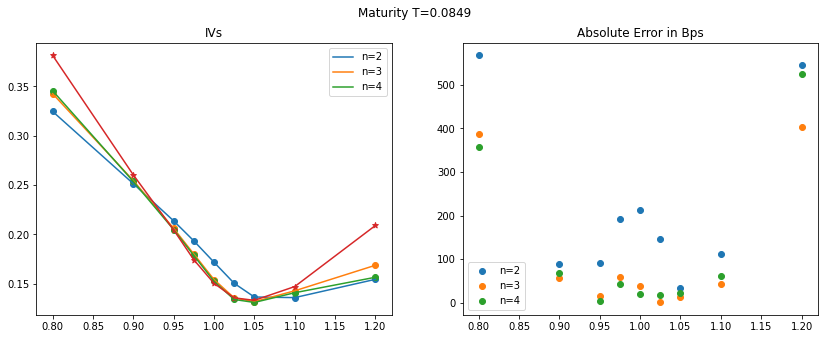

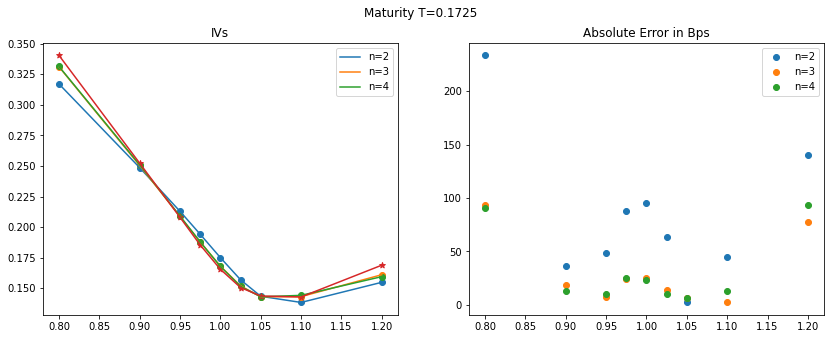

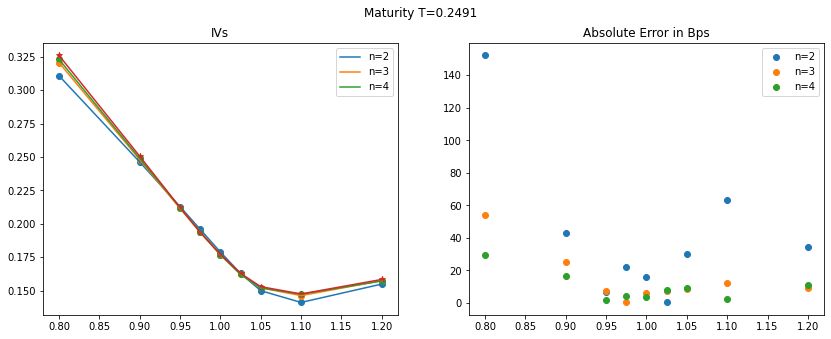

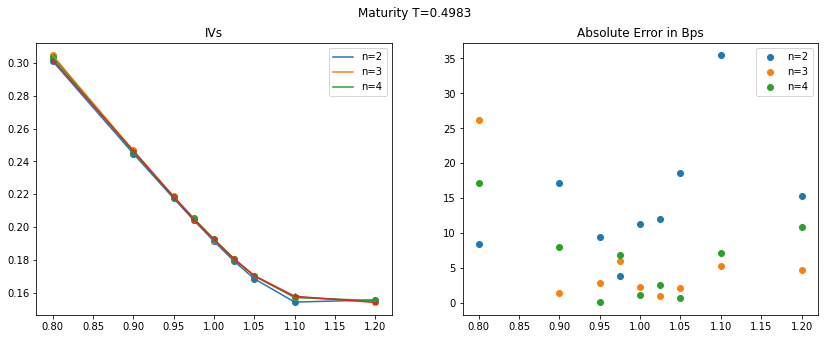

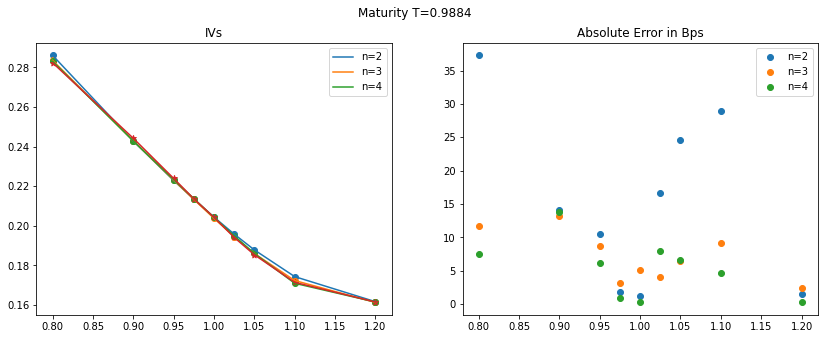

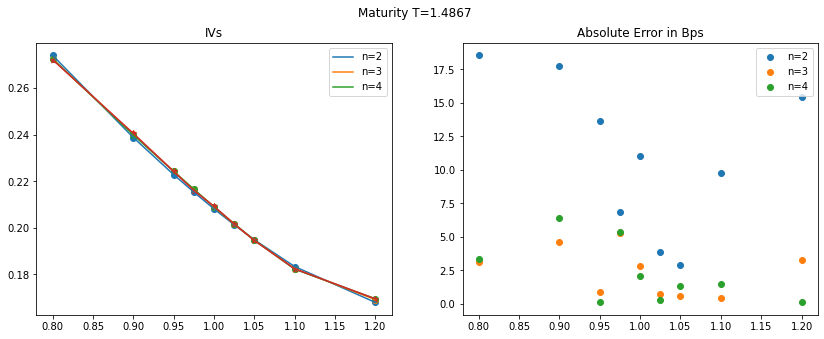

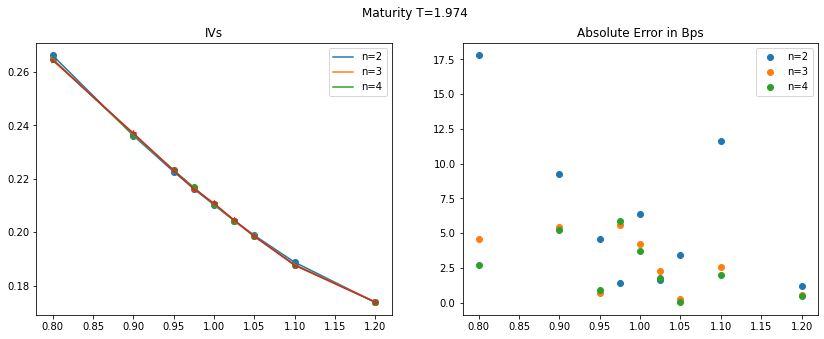

In [47]:
for j in range(len(maturities)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
    fig.suptitle('Maturity T={}'.format(round(maturities[j],4)))
    #ax1.plot(strikes[j], iv_calib_mc1_arr[j])
    #ax1.scatter(strikes[j], iv_calib_mc1_arr[j])
    ax1.plot(strikes[j], iv_calib_mc2_arr[j],label='n=2')
    ax1.scatter(strikes[j], iv_calib_mc2_arr[j])
    ax1.plot(strikes[j], iv_calib_mc3_arr[j],label='n=3')
    ax1.scatter(strikes[j], iv_calib_mc3_arr[j])
    ax1.scatter(strikes[j], iv_calib_mc4_arr[j])
    ax1.plot(strikes[j], iv_calib_mc4_arr[j],label='n=4')
    
    
    
    ax1.plot(strikes[j], iv_market[j])
    ax1.scatter(strikes[j], iv_market[j],marker='*')
    

    
    
    ax2.scatter(strikes[j],np.abs(iv_calib_mc2_arr[j]-iv_market[j])*10000,label='n=2')
    ax2.scatter(strikes[j],np.abs(iv_calib_mc3_arr[j]-iv_market[j])*10000,label='n=3')
    ax2.scatter(strikes[j],np.abs(iv_calib_mc4_arr[j]-iv_market[j])*10000,label='n=4')
    
    
    ax1.set_title('IVs')
    ax2.set_title('Absolute Error in Bps')
    
    ax1.legend(loc='best')
    ax2.legend(loc='best')
    plt.show()



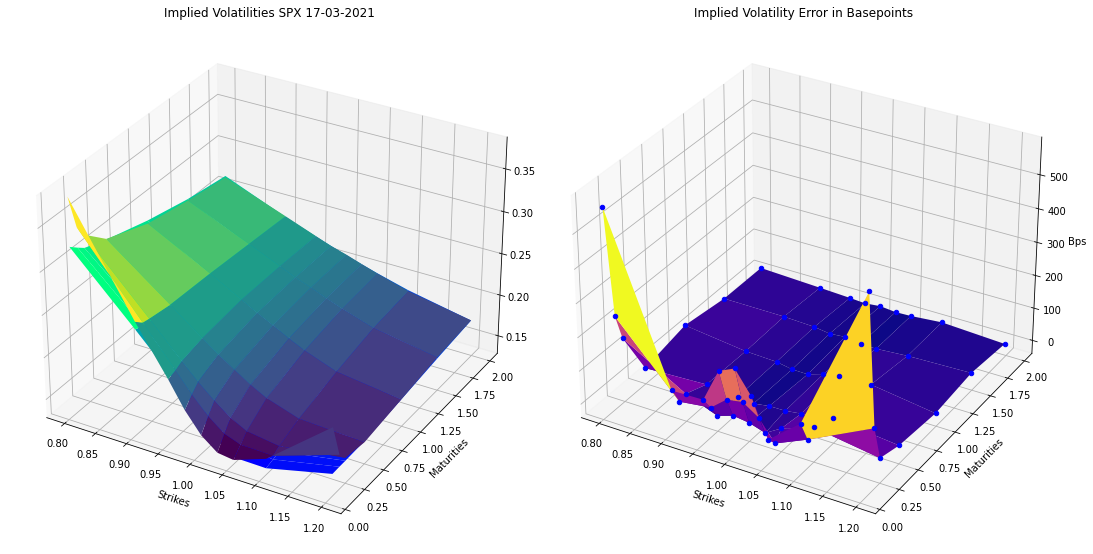

In [48]:
YY=np.array([[maturities[j]]*(len(strikes[0])) for j in range(len(maturities))])
%matplotlib inline

# set up a figure twice as wide as it is tall
fig = plt.figure(figsize=(15,8))

# =============
# First subplot
# =============
# set up the axes for the first plot
ax = fig.add_subplot(1, 2, 1, projection='3d')

surf = ax.plot_surface(norm_strikes, YY, iv_market, rstride=1, cstride=1, cmap=cm.viridis,linewidth=0.5)
ax.plot_surface(norm_strikes, YY, iv_calib_mc2_arr, rstride=1, cstride=1, cmap=cm.winter,linewidth=0.5)
#ax.scatter(norm_strikes, YY, iv_calib_mc2_arr, s=30,marker='o', c='red',depthshade=False)
#ax.scatter(norm_strikes, YY, iv_market, s=20,marker='*', c='blue',depthshade=False)

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
#ax.set_zlabel('IV')
ax.set_title('Implied Volatilities SPX 17-03-2021');
#ax.set_zlim(-1.01, 1.01)
#fig.colorbar(surf, shrink=0.5, aspect=10)

# ==============
# Second subplot
# ==============
# set up the axes for the second plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(norm_strikes, YY, np.abs(np.array(iv_calib_mc2_arr)-iv_market)*10000, rstride=1, cstride=1,
                cmap=cm.plasma,linewidth=0.5, edgecolor='none')

ax.scatter(norm_strikes, YY, np.abs(np.array(iv_calib_mc2_arr)-iv_market)*10000, s=20, c='blue',depthshade=False)
#ax.plot_surface(strikes, YY, np.array(iv_mc), rstride=1, cstride=1,
#                cmap=cm.magma,linewidth=0.5, edgecolor='none')

ax.set_xlabel('Strikes')
ax.set_ylabel('Maturities')
ax.set_zlabel('Bps')
ax.set_title('Implied Volatility Error in Basepoints');
#plt.savefig('IV_surface_SPXMC_constant.png',dpi=180)
plt.tight_layout()
plt.show()